In [ ]:
import numpy as np
import scipy.linalg as linalg
import scipy.special as scsp
import matplotlib.pyplot as plt
from itertools import permutations
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


AUXILIARY FUNCTIONS

In [ ]:
#Swapping two elements in a string along x
def swap_x(s, i, j):
    lst = list(s)
    lst[i], lst[j] = lst[j], lst[i]
    return ''.join(lst)

#Swapping two elements in two strings along y
def swap_y(Down, Up, i):
    lst_d = list(Down)
    lst_u = list(Up)
    lst_d[i], lst_u[i] = lst_u[i], lst_d[i]
    return ''.join(lst_d) , ''.join(lst_u)


#Shifting a string to the left
def left_shift(num,n):
    return num[n:]+num[:n]
#Shifting a string to the right
def right_shift(num,n):
    return num[-n:]+num[:-n]

#Generating the set of cyclic permutations of an array 'A'
def cyclic_y(A):
    n = len(A)
    out=np.reshape(A,newshape=(1,n))
    for i in range(1,n):
        a=np.reshape(np.append(A[i:],A[:i]),newshape=(1,n))
        if( (a==A).all() ): return out
        out=np.append(out,a,axis=0)
        
    return out

#From chain of lenght N=len(row) gives the 2d corresponding state with lenght Nx*Ny 
def PermToStates(row,Ny):
    l=int(len(row)/Ny)
    Full=np.array([0])
    for i in range(0,Ny):
        #Full=np.append(Full,np.array(BitToIndex[''.join(list(row)[i*l:l*(i+1)])]))
        Full=np.append( Full,np.array(BitToIndex[ row[i*l:l*(i+1)] ]) )
    return np.delete(Full,0,axis=0)

#Compute Sz
def ValSz(State):
    Sz=int(-N/2)
    for row in State:
        Sz += sum(list(map(int,list(list(Canonical_Basis_bit[row])))))
    return Sz

COMPUTING THE NORM OF "RepresQxQy" STATES FOR (qx,qy)

In [ ]:
def NormQxQy(RepresQxQy,qx,qy,Nx,Ny):
  NN=Nx*Ny
  NormStatesQxQy = np.zeros(len(RepresQxQy))
  period=np.array([[Nx,Ny]]*len(RepresQxQy))
  for r,rep in enumerate(RepresQxQy):
    states=set()
    for x in np.arange(0,Nx):
          
      ax=np.array(list(map((lambda z: BitToIndex[left_shift(Canonical_Basis_bit[z],x)]), rep)))
      for y in np.arange(0,Ny):
        a=np.append(ax[y:],ax[:y])
        states.add(str(a))
       
    LenStates=len(states)
    status=np.zeros(LenStates,dtype=complex)
    StateToIndex=dict(zip(states,np.arange(0,LenStates)))
    if (LenStates==NN):
      NormStatesQxQy[r]=np.sqrt(NN)
    else:
      for x in np.arange(0,Nx):
        ax=np.array(list(map((lambda z: BitToIndex[left_shift(Canonical_Basis_bit[z],x)]), rep)))
        for y in np.arange(0,Ny):
          a=np.append(ax[y:],ax[:y])
          status[StateToIndex[str(a)]] +=np.exp(1j*(y*qy+x*qx))
      norm=np.linalg.norm(status)
      NormStatesQxQy[r]=norm

  return NormStatesQxQy


SYMMETRY: GETTING THE REPRESENTATIVE STATE AND THE TRASLATIONS

In [ ]:
#Checking which representative and how many translations along x and y
def check_rep_xy(Status,SetRepQxQy,IndexRepQxQy,RepQxQy,Nx,Ny,r):
    Stat=Status.copy()
    info=False
    for jx in np.arange(0,Nx):
        
        for jy in np.arange(0,Ny):
            Stat[jy]=BitToIndex[right_shift(Canonical_Basis_bit[Status[jy]],jx)]

        for jy in np.arange(0,Ny):
            s=np.append(Stat[jy:],Stat[:jy])
            if ( str(s) in SetRepQxQy ):
                index=IndexRepQxQy[str(s)]
                if (index!=r):
                    info = True
                    return info,jx,jy,index
                else:
                  print('PROBLEM check_rep_xy')
    return info, 0, 0, 0



REP STATES OF Nx AND Ny

In [ ]:
#Total Rep States at fixed Nx and Ny
def RepresQX(Nx,Ny,Sz_here):
    
    Ntot=Nx*Ny
    RepresXY=np.zeros(shape=(1,Ny),dtype=int)
    
    ChainStates=np.array([np.binary_repr(2**int(Ntot/2)-1,width=Ntot)])

    for i in range(2**int(Ntot/2),2**Ntot):
        if( bin(i).count('1')==(Ntot/2)):
            b=np.binary_repr(i,width=Ntot)
            ChainStates=np.append(ChainStates,b)

    FullStates=np.array(list(map(lambda x: PermToStates(x,Ny),ChainStates)))
    
    #second=np.unique(np.array(list(it.permutations(first))),axis=0)
    #FullStates=np.array(list(map(lambda x: PermToStates(x,Ny),second)))
    
    StatesXY=set()
    for Stat in FullStates:
        Sz_Stat=ValSz(Stat)
        if ((Sz_Stat==Sz_here)and(not(str(Stat) in StatesXY))):
            RepresXY=np.append(RepresXY,np.reshape(Stat,newshape=(1,Ny)),axis=0)
            
            states=np.reshape(Stat,newshape=(1,Ny))
            for jx in np.arange(1,Nx):
                a=np.array(list(map(lambda x: BitToIndex[right_shift(Canonical_Basis_bit[x],jx)],Stat)))
                states=np.append(states,np.reshape(a,newshape=(1,Ny)),axis=0)
            
            if (Ny>1):
              Cyc=cyclic_y(states[0])
              for row in states[1:]:
                  Cyc=np.append(Cyc,cyclic_y(row),axis=0)
            else:
              Cyc=states

            StatesXY.update( list(map(str,Cyc)))
        
    #return FullStates
    return np.delete(RepresXY,0,axis=0), np.array(list(StatesXY))


IMPLEMENTING THE  HAMILTONIAN ELEMENTS APPLIED TO REPRESENTATIVES


In [ ]:
#Create the full Hamiltonian in the qx,qy sector.
def H_Qxy(q_x,q_y,RepQxQy,NormStatesQxQy,Nx,Ny):
    dimQ=len(RepQxQy)
    H = np.zeros(shape=(dimQ,dimQ),dtype=complex)
    ListRepQxQy=list(map(str,RepQxQy))
    SetRepQxQy=set(ListRepQxQy)
    IndexRepQxQy = dict(zip(ListRepQxQy,np.arange(0,dimQ)))
    for r,rep in enumerate(RepQxQy):
        
        
        for i_y in np.arange(0,Ny):

            #Bit representation of two consecutive rows
            Stat_i_y = Canonical_Basis_bit[rep[i_y]]
            if (Ny>1):
                inext_y=((i_y+1) % Ny)
                Stat_inext_y = Canonical_Basis_bit[rep[inext_y]]

            for i_x in np.arange(0,Nx):
                inext_x=((i_x+1) % Nx)
                
                #Diagonal Terms
                H[r,r] += 0.25*(-1)**(int(Stat_i_y[i_x])+int(Stat_i_y[inext_x])) #along x
                if (Ny>1):
                  H[r,r] += 0.25*(-1)**(int(Stat_i_y[i_x])+int(Stat_inext_y[i_x])) #along y

                Status=rep.copy()
                
###########     ALONG X     ###########

                MinusPlus = Stat_i_y.copy()
                #Terms from S^- S^+
                if ( (MinusPlus[i_x]=='1')and(MinusPlus[inext_x]=='0') ):
                    MinusPlus=swap_x(MinusPlus,i_x,inext_x)
                    Status[i_y]=BitToIndex[MinusPlus]
                    info,jx,jy,rQxQy = check_rep_xy(Status,SetRepQxQy,IndexRepQxQy,RepQxQy,Nx,Ny,r)
                    if (info):
                        H[rQxQy,r] += 0.5*np.exp(1j*(q_x*jx+q_y*jy))*NormStatesQxQy[rQxQy]/NormStatesQxQy[r]
                #Terms for S^+ S^-
                elif ((MinusPlus[i_x]=='0')and(MinusPlus[inext_x]=='1') ):
                    MinusPlus=swap_x(MinusPlus,i_x,inext_x)
                    Status[i_y]=BitToIndex[MinusPlus]
                    info,jx,jy,rQxQy = check_rep_xy(Status,SetRepQxQy,IndexRepQxQy,RepQxQy,Nx,Ny,r)
                    if (info):
                        H[rQxQy,r] += 0.5*np.exp(1j*(q_x*jx+q_y*jy))*NormStatesQxQy[rQxQy]/NormStatesQxQy[r]
                
                
                
###########     ALONG Y     ###########

                if (Ny>1):
                  Status=rep.copy()
                  #Terms from S^- S^+
                  MinusPlusDown = Stat_i_y.copy()
                  MinusPlusUp = Stat_inext_y.copy()
                  if ( (MinusPlusDown[i_x]=='1') and (MinusPlusUp[i_x]=='0') ):
                    
                    MinusPlusDown, MinusPlusUp = swap_y(MinusPlusDown,MinusPlusUp,i_x)
                    Status[i_y]=BitToIndex[MinusPlusDown]
                    Status[inext_y]=BitToIndex[MinusPlusUp]
                    info,jx,jy,rQxQy = check_rep_xy(Status,SetRepQxQy,IndexRepQxQy,RepQxQy,Nx,Ny,r)
                    if (info):
                      H[rQxQy,r] += 0.5*np.exp(1j*(q_x*jx+q_y*jy))*NormStatesQxQy[rQxQy]/NormStatesQxQy[r]
                                
                  #Terms from S^+ S^-
                  elif ( (MinusPlusDown[i_x]=='0') and (MinusPlusUp[i_x]=='1') ):
                    
                    MinusPlusDown, MinusPlusUp = swap_y(MinusPlusDown,MinusPlusUp,i_x)
                    Status[i_y] = BitToIndex[MinusPlusDown]
                    Status[inext_y] = BitToIndex[MinusPlusUp]
                    info,jx,jy,rQxQy = check_rep_xy(Status,SetRepQxQy,IndexRepQxQy,RepQxQy,Nx,Ny,r)
                    if (info):
                      H[rQxQy,r] += 0.5*np.exp(1j*(q_x*jx+q_y*jy))*NormStatesQxQy[rQxQy]/NormStatesQxQy[r]
                                
    return H


In [ ]:
N=16
dimHtot=2**N
Sz=0
NxVal  = [8,10,12,14,16]
NxName = ["8","10","12","14","16"]

print('If all correct then Total States=',scsp.binom(N,int(N/2)))
EnVec = {}
  
for iNx,Nx in enumerate(NxVal):
  #Ny=int(N/Nx)
  Ny=1
  dimHx=2**Nx
  N=Nx
  momenta_x=np.arange(0,Nx)*2*np.pi/Nx
  momenta_y=np.arange(0,Ny)*2*np.pi/Ny

  print('Canonical Basis for Nx =',Nx,'...')
  Canonical_Basis_bit = np.array([np.binary_repr(0,width=Nx)])
  for i in range(1,dimHx):
    b=np.binary_repr(i,width=Nx)
    Canonical_Basis_bit=np.append(Canonical_Basis_bit,b)
  #Mapping from config to index
  BitToIndex=dict(zip(Canonical_Basis_bit,np.arange(0,len(Canonical_Basis_bit))))
  w = np.array([])
  t1= time.perf_counter()
  print('Building representative states...')
  NumConfig=0
  t1q=time.perf_counter()
  RepresXY,States=RepresQX(Nx,Ny,Sz)
  t2q=time.perf_counter()
  Nstates = len(States)
  print('RepresXY,States:',len(RepresXY),'Total States:',Nstates)
  print('RepresXY t:',t2q-t1q)
  #print(Canonical_Basis_bit[RepresXY])
  ConfigToIndex = dict(zip(list(map(str,States)),range(0,Nstates)))
  for qx in momenta_x[:]:   
    for qy in momenta_y[:]:
      print(' qx,qy:',qx,qy)

      t1q = time.perf_counter()
      NormStatesQxQy = NormQxQy(RepresXY,qx,qy,Nx,Ny)
      t2q = time.perf_counter()
      print('  Norm t:', t2q-t1q)

      #print(Canonical_Basis_bit[RepresXY],NormStatesQxQy)
      RepresQxQy=RepresXY[NormStatesQxQy>1.0e-13]
      NormStatesQxQy=NormStatesQxQy[NormStatesQxQy>1.0e-13]
      NumConfig += len(RepresQxQy)

      t1q = time.perf_counter()
      H_qx_qy = H_Qxy(qx,qy,RepresQxQy,NormStatesQxQy,Nx,Ny)
      t2q = time.perf_counter()
      print('  H_built t:', t2q-t1q)

      t1q = time.perf_counter()
      w_q, w_vec = np.linalg.eigh(H_qx_qy)
      t2q = time.perf_counter()
      print('  H_diag t:',t2q-t1q)

      w = np.append(w,w_q)
      
      #plt.hist(w_q,bins=w_bins)
      #plt.title("q: "+str(q)) 
      #plt.show()
  t2= time.perf_counter()
  print('NumConfig:',NumConfig)
  w=np.sort(w)
  #np.savetxt("16x1.txt", w , fmt="%s")
  print('For Nx =', Nx, ' - len: ',len(w),'   - t (s):',t2-t1)
  EnVec.update({NxName[iNx]:w})
  print('*************')

If all correct then Total States= 12870.0
Canonical Basis for Nx = 8 ...
Building representative states...
RepresXY,States: 10 Total States: 70
RepresXY t: 0.010201296000104776
 qx,qy: 0.0 0.0
  Norm t: 0.011139333999835799
  H_built t: 0.011580451000099856
  H_diag t: 0.0008937510001487681
 qx,qy: 0.7853981633974483 0.0
  Norm t: 0.011633970999810117
  H_built t: 0.015893017000053078
  H_diag t: 0.0003082039997934771
 qx,qy: 1.5707963267948966 0.0
  Norm t: 0.010828126999967935
  H_built t: 0.016899535999982618
  H_diag t: 0.0005971479999971052
 qx,qy: 2.356194490192345 0.0
  Norm t: 0.010899060999690846
  H_built t: 0.018053445000077772
  H_diag t: 0.00021391499967648997
 qx,qy: 3.141592653589793 0.0
  Norm t: 0.011150056999667868
  H_built t: 0.011856442999942374
  H_diag t: 0.00033667699972284026
 qx,qy: 3.9269908169872414 0.0
  Norm t: 0.010596288000215281
  H_built t: 0.013633391999974265
  H_diag t: 0.00030935799986764323
 qx,qy: 4.71238898038469 0.0
  Norm t: 0.0104618929999560

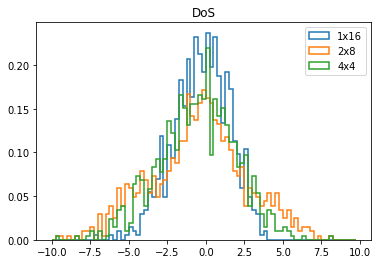

In [ ]:
#print(w_bins)

#KEEP COMMENTED IF THE w HAS BEEN LOADED
w1=np.sort(EnVec["16"])
w2=np.sort(EnVec["8"])
w4=np.sort(EnVec["4"])


w_bins=np.arange(-10,10,0.25)
entries, bin_edges, patches = plt.hist(w1,bins=w_bins,density=True,lw=1.5,label='1x16',histtype='step')
entries, bin_edges, patches = plt.hist(w2,bins=w_bins,density=True,lw=1.5,label='2x8',histtype='step')
entries, bin_edges, patches = plt.hist(w4,bins=w_bins,density=True,lw=1.5,label='4x4',histtype='step')
#entries, bin_edges, patches = plt.hist(ww[2],bins=w_bins,density=True,label='2')
plt.title("DoS") 
plt.legend()
plt.show()
#print(w[:20])
#print('E_0/N:',w[0]/N)
#plt.plot(range(0,len(w)),w,marker='o')


In [ ]:
l1=len(w1)
l2=len(w2)
l4=len(w4)
print('l:',l1,l2,l4)
dTreshold = 1e-15

d1=np.diff(np.unique(w1))
d1=d1[d1>dTreshold]
l1_pos=len(d1)
r1=np.minimum(d1[1:],d1[0:-1]) / np.maximum(d1[1:],d1[0:-1])
d1_bin=np.arange(np.min(d1),np.max(d1),0.01 )

d2=np.diff(np.unique(w2))
d2=d2[d2>dTreshold]
l2_pos=len(d2)
r2=np.minimum(d2[1:],d2[0:-1]) / np.maximum(d2[1:],d2[0:-1])
d2_bin=np.arange(np.min(d2),np.max(d2),0.01 )

d4=np.diff(np.unique(w4))
d4=d4[d4>dTreshold]
l4_pos=len(d4)
r4=np.minimum(d4[1:],d4[0:-1]) / np.maximum(d4[1:],d4[0:-1])
d4_bin=np.arange(np.min(d4),np.max(d4),0.01 )

#r=np.sort(r)
#rmax=r[-1]
#rmin=r[0]


r_bin=np.arange(0,1,0.005)
#plt.legend()

l: 810 820 822


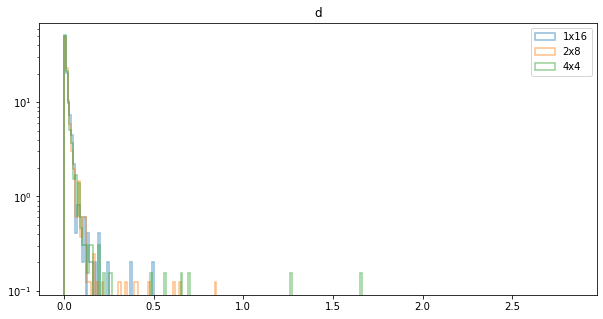

For 1x16 <d>: 0.022601006816666686
For 2x8 <d>: 0.02655876646253001
For 4x4 <d>: 0.029536840565942867
**************************


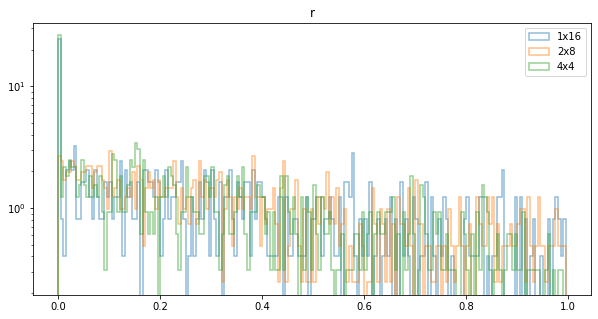

For 1x16 <r>: 0.3447392248073246
For 2x8 <r>: 0.3726835086437847
For 4x4 <r>: 0.31336380370761563
<r>_Poisson = 2ln(2) -1 = 0.386
**************************


In [ ]:
# d histogram
FigureSize=(10,5)
if(True):
  plt.figure(figsize=FigureSize) 
  plt.title("d")
  plt.hist(d1,bins=d1_bin,density=True,label='1x16',lw=1.5,alpha=0.5,histtype='step')
  plt.hist(d2,bins=d2_bin,density=True,label='2x8',lw=1.5,alpha=0.5,histtype='step')
  plt.hist(d4,bins=d4_bin,density=True,label='4x4',lw=1.5,alpha=0.5,histtype='step')
  plt.yscale('log')
  plt.legend()
  plt.show()
  print('For 1x16 <d>:',np.mean(d1))
  print('For 2x8 <d>:',np.mean(d2))
  print('For 4x4 <d>:',np.mean(d4))
  print('**************************')
# r histogram
if(True):
  plt.figure(figsize=FigureSize)
  plt.title('r')
  entries, bin_edges, patches = plt.hist(r1,bins=r_bin,density=True,label='1x16',lw=1.5,alpha=0.5,histtype='step')
  entries, bin_edges, patches = plt.hist(r2,bins=r_bin,density=True,label='2x8',lw=1.5,alpha=0.5,histtype='step')
  entries, bin_edges, patches = plt.hist(r4,bins=r_bin,density=True,label='4x4',lw=1.5,alpha=0.5,histtype='step')
  plt.yscale('log')
  plt.legend()
  plt.show()
  print('For 1x16 <r>:',np.mean(r1))
  print('For 2x8 <r>:',np.mean(r2))
  print('For 4x4 <r>:',np.mean(r4))
  print('<r>_Poisson = 2ln(2) -1 = 0.386')
  print('**************************')

In [ ]:
print('Caso 16x1')
print('E_0:',w1[0],'E_0 / N:',w1[0]/16, ' - <E>: ', np.mean(w1))
print('Caso 8x2')
print('E_0:',w2[0],'E_0 / N:',w2[0]/16,' - <E>: ', np.mean(w2))
print('Caso 4x4')
print('E_0:',w4[0],'E_0 / N:',w4[0]/16,' - <E>: ', np.mean(w4))

Caso 16x1
E_0: -7.142296360616778 E_0 / N: -0.44639352253854864  - <E>:  -0.26666666666666666
Caso 8x2
E_0: -13.751629732812077 E_0 / N: -0.8594768583007548  - <E>:  -0.5333333333333334
Caso 4x4
E_0: -11.228483208428862 E_0 / N: -0.7017802005268039  - <E>:  -0.5333333333333332




SAVING AND LOADING CELLS

In [ ]:
#Save the Energies for 16x1 , 8x2 , 4x4
if(False):
  np.savetxt('Energies_16x1.txt', w1, fmt='%.16f', delimiter=' ')
  np.savetxt('Energies_8x2.txt', w2, fmt='%.16f', delimiter=' ')
  np.savetxt('Energies_4x4.txt', w4, fmt='%.16f', delimiter=' ')
if(False):
  np.savetxt('Energies_16x1_mom0.txt', w1, fmt='%.16f', delimiter=' ')
  np.savetxt('Energies_8x2_mom0.txt', w2, fmt='%.16f', delimiter=' ')
  np.savetxt('Energies_4x4_mom0.txt', w4, fmt='%.16f', delimiter=' ')


In [ ]:
#Load the Energies for 16x1 , 8x2 , 4x4
if(True):
  w1 = np.loadtxt('Energies_16x1.txt', delimiter=' ')
  w2 = np.loadtxt('Energies_8x2.txt', delimiter=' ')
  w4 = np.loadtxt('Energies_4x4.txt', delimiter=' ')
if(False):
  w1 = np.loadtxt('Energies_16x1_mom0.txt', delimiter=' ')
  w2 = np.loadtxt('Energies_8x2_mom0.txt', delimiter=' ')
  w4 = np.loadtxt('Energies_4x4_mom0.txt', delimiter=' ')

OSError: ignored

In [ ]:
f = open("Exact_half.txt", "a")
f.write(str( np.append(np.sort(EnVec["16"])[0:2],16.0))[1:-1]+'\n')
f.write(str( np.append(np.sort(EnVec["14"])[0:2],14.0))[1:-1]+'\n')
f.write(str( np.append(np.sort(EnVec["12"])[0:2],12.0))[1:-1]+'\n')
f.write(str( np.append(np.sort(EnVec["10"])[0:2],10.0))[1:-1]+'\n')
f.write(str( np.append(np.sort(EnVec["8"])[0:2],8.0))[1:-1]+'\n')
f.close()

array([], dtype=float64)